<a href="https://colab.research.google.com/github/Kimjibeom/Project_Book/blob/main/TextRank(News_example).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TextRank

사용자가 입력한 url에서 text를 크롤링 해주는 패키지

In [1]:
pip install newspaper3k

KoNLPy 설치하기 위한 패키지

In [2]:
pip install jpype1

한글형태소 분석기- TextRank를 적용하기 위한 전처리 과정

In [3]:
pip install konlpy

TF-IDF 모델 생성

In [4]:
pip install scikit-learn

In [5]:
from newspaper import Article
from konlpy.tag import Kkma
from konlpy.tag import Okt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
import numpy as np

# 1. 문서 타입에 따른 문장 단위로 분리하기

1. 텍스트 크롤링
2. 문장 단위 분리
3. 명사 추출(POS-Tagging)



# SentenceTokenizer Class
클래스로 구현

In [6]:
class SentenceTokenizer(object):
  def __init__(self):
    self.kkma = Kkma()
    self.twitter = Okt()
    # 불용어 처리
    self.stopwords = []

# url 주소를 받아 기사내용을 추출하여 문장단위로 나눠준 뒤 return  
  def url2sentences(self, url):
    article = Article(url, language='ko')
    article.download()
    article.parse()
    sentences = self.kkma.sentences(article.text)
    
    for idx in range(0, len(sentences)):
      if len(sentences[idx]) <= 10:
        sentences[idx-1] += (' ' + sentences[idx])
        sentences[idx] = ''
    return sentences

# text(str)를 입력 받아 Kkma.sentences()를 이용하여 문장단위로 나눈 뒤 sentences를 return
  def text2sentences(self, text): 
    sentences = self.kkma.sentences(text)
    for idx in range(0, len(sentences)):
      if len(sentences[idx]) <= 10:
        sentences[idx-1] += (' ' + sentences[idx])
        sentences[idx] = ''
    return sentences

# sentences를 받아 Twitter.nouns()를 이용하여 명사를 추출한 뒤 nouns를 return
  def get_nouns(self, sentences):
    nouns = []
    for sentence in sentences:
      if sentence is not '':
        nouns.append(' '.join([noun for noun in self.twitter.nouns(str(sentence))
                              if noun not in self.stopwords and len(noun) > 1]))
    return nouns

# 2. TF-IDF 모델 생성 및 그래프 생성

1. TF-IDF(Term Frequency - Inverse Document Frequency)는 정보 검색(Information Retrieval)과 텍스트 마이닝에서 사용하는 단어의 상대적인 가중치


* TF(Term Frequency) : 단어 빈도, 특정 단어가 문서 내에 얼만큼의 빈도로 등장하는지를 나타내는 척도

* IDF(Inverse Document Frequency) : 역문헌 빈도수, 문서 빈도의 역수로써 전체 문서 개수를 해당 단어가 포함된 문서의 개수로 나눈 것을 의미

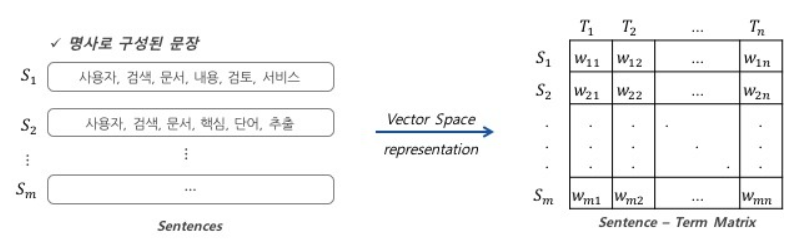

2. 그래프 생성
Sentence-Term Matrix를 이용하여 전치행렬을 구한뒤 서로 곱해준다. 
즉, Correlation Matrix 를 생성

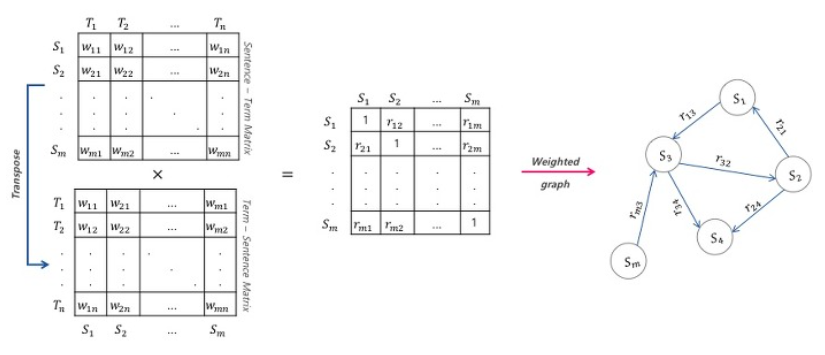

In [7]:
class GraphMatrix(object):

  def __init__(self):
    self.tfidf = TfidfVectorizer()
    self.cnt_vec = CountVectorizer()
    self.graph_sentence = []

# 명사로 이루어진 문장을 입력받아 sklearn의 TfidfVectorizer.fit_transform을 이용하여 tfidf matrix를 만든 후 Sentence graph를 return
  def build_sent_graph(self, sentence):
    tfidf_mat = self.tfidf.fit_transform(sentence).toarray()
    self.graph_sentence = np.dot(tfidf_mat, tfidf_mat.T)
    return self.graph_sentence

#명사로 이루어진 문장을 입력받아 sklearn의 CountVectorizer.fit_transform을 이용하여 matrix를 만든 후 word graph와 {idx: word}형태의 dictionary를 return
  def build_words_graph(self, sentence):
    cnt_vec_mat = normalize(self.cnt_vec.fit_transform(sentence).toarray().astype(float), axis=0)
    vocab = self.cnt_vec.vocabulary_
    return np.dot(cnt_vec_mat.T, cnt_vec_mat), {vocab[word] : word for word in vocab}

# 3. TextRank 알고리즘 적용
가중치 그래프를 이용하여 TextRank 알고리즘을 적용

In [8]:
class Rank(object):
  def get_ranks(self, graph, d=0.85): # d = damping factor
    A = graph
    matrix_size = A.shape[0]
    for id in range(matrix_size):
      A[id, id] = 0 # diagonal 부분을 0으로
      link_sum = np.sum(A[:,id]) # A[:, id] = A[:][id]
      if link_sum != 0:
        A[:, id] /= link_sum
      A[:, id] *= -d
      A[id, id] = 1

    B = (1-d) * np.ones((matrix_size, 1))
    ranks = np.linalg.solve(A, B) # 연립방정식 Ax = b
    return {idx: r[0] for idx, r in enumerate(ranks)}

# 4. TextRank Class 구현
* summarize(sent_num=3): Default로 3줄 요약 가능하게 구현
* keywords(word_num=10): Default로 10개의 키워드를 출력하도록 구현

In [9]:
class TextRank(object):
  def __init__(self, text):
    self.sent_tokenize = SentenceTokenizer()

    if text[:5] in ('http:', 'https'):
       self.sentences = self.sent_tokenize.url2sentences(text)
    else:
      self.sentences = self.sent_tokenize.text2sentences(text)

    self.nouns = self.sent_tokenize.get_nouns(self.sentences)

    self.graph_matrix = GraphMatrix()
    self.sent_graph = self.graph_matrix.build_sent_graph(self.nouns)
    self.words_graph, self.idx2word = self.graph_matrix.build_words_graph(self.nouns)


    self.rank = Rank()
    self.sent_rank_idx = self.rank.get_ranks(self.sent_graph)
    self.sorted_sent_rank_idx = sorted(self.sent_rank_idx, key=lambda k: self.sent_rank_idx[k], reverse=True)


    self.word_rank_idx = self.rank.get_ranks(self.words_graph)
    self.sorted_word_rank_idx = sorted(self.word_rank_idx, key=lambda k: self.word_rank_idx[k], reverse=True)


  def summarize(self, sent_num=3):
    summary = []
    index=[]
    for idx in self.sorted_sent_rank_idx[:sent_num]:
      index.append(idx)
    
    index.sort()
    for idx in index:
      summary.append(self.sentences[idx])

    return summary


  def keywords(self, word_num=10):
    rank = Rank()
    rank_idx = rank.get_ranks(self.words_graph)
    sorted_rank_idx = sorted(rank_idx, key=lambda k: rank_idx[k], reverse=True)


    keywords = []
    index=[]
    for idx in sorted_rank_idx[:word_num]:
      index.append(idx)


    #index.sort()
    for idx in index:
      keywords.append(self.idx2word[idx])


    return keywords

# 5. 결과 확인


In [2]:
url = 'https://www.naver.com/'
textrank = TextRank(url)
for row in textrank.summarize(3):
  print(row)
  print()
print('keywords :',textrank.keywords())

NameError: ignored